In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight

from sklearn.preprocessing import label_binarize

In [5]:
# 1. Parameters
IMAGE_SIZE  = (224, 224)
BATCH_SIZE  = 32
LEARNING_RATE = 1e-4
train_dir = '../../data5/train'
test_dir  = '../../data5/test'

# Create data generators with VGG16-specific preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Using the test set as "validation_data" (not ideal practice)
# but shown here due to the 2-folder constraint:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Malign']


In [6]:
# 1) Load VGG16 pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 2) Decide how many layers to freeze
#    VGG16 has 19 layers (if you count the major layers).
#    We'll freeze the first 10 layers and unfreeze the rest.

for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True

# 3) Build a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  
# Optional dropout for regularization
x = Dropout(0.5)(x)  
# Final dense layer for our N-class classification
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 12,981,252 (49.52 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1381s 7s/step - accuracy: 0.4550 - loss: 1.2452 - val_accuracy: 0.6316 - val_loss: 0.8887 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1393s 7s/step - accuracy: 0.6177 - loss: 0.8882 - val_accuracy: 0.6832 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1389s 7s/step - accuracy: 0.6655 - loss: 0.7616 - val_accuracy: 0.6863 - val_loss: 0.7297 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1393s 7s/step - accuracy: 0.7319 - loss: 0.6426 - val_accuracy: 0.7333 - val_loss: 0.6597 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1382s 7s/step - accuracy: 0.7454 - loss: 0.6276 - val_accuracy: 0.7314 - val_loss: 0.7294 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1393s 7s/step - accuracy: 0.7688 - loss: 0.5820 - val_accuracy: 0.7609 - val_loss: 0.6081 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1398s 7s/ste

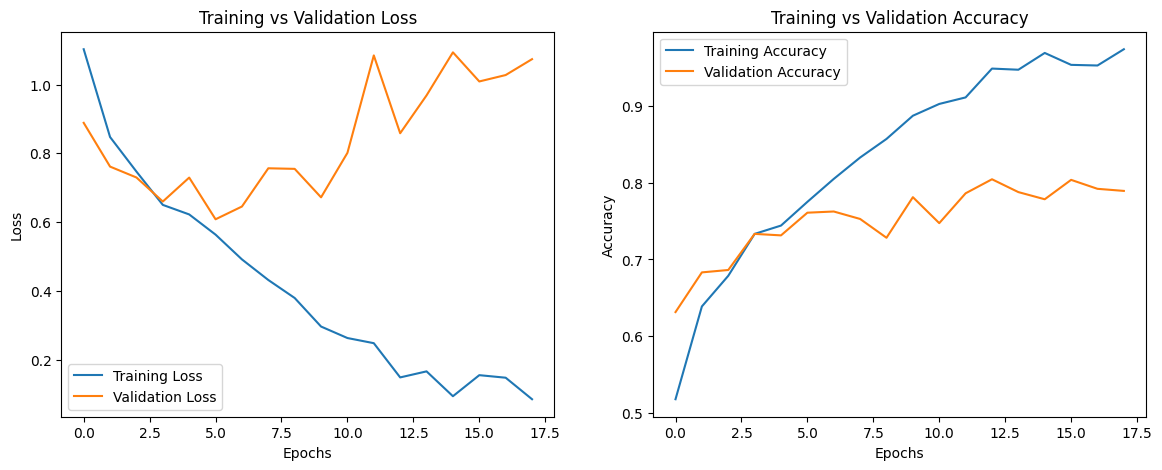

In [11]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Test Loss: 0.858443558216095
Test Accuracy: 0.804347813129425


In [14]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.08166103810071945
Train Accuracy: 0.9713285565376282


81/81 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step

Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.66      0.77      0.71       650
      2. Ekzama       0.75      0.71      0.73       650
        3. Akne       0.91      0.88      0.89       626
      4. Malign       0.94      0.86      0.90       650

       accuracy                           0.80      2576
      macro avg       0.81      0.81      0.81      2576
   weighted avg       0.81      0.80      0.81      2576

Confusion Matrix:
[[503 103  29  15]
 [163 459  19   9]
 [ 39  25 549  13]
 [ 60  21   8 561]]


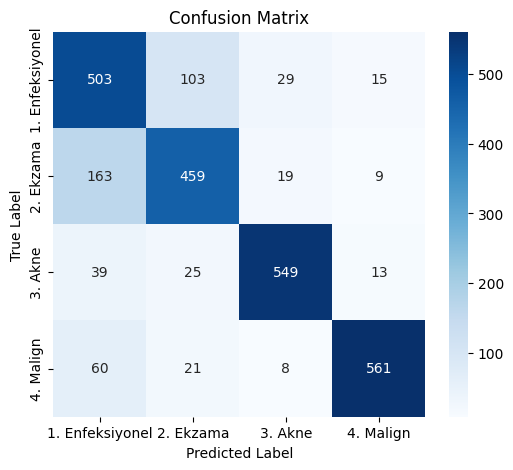

In [13]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 960ms/step - accuracy: 0.8059 - loss: 0.7916
Val Loss: 0.6329536437988281
Val Accuracy: 0.8555900454521179


Macro-average ROC AUC: 0.9456165443222787
Micro-average ROC AUC: 0.9510118585477668


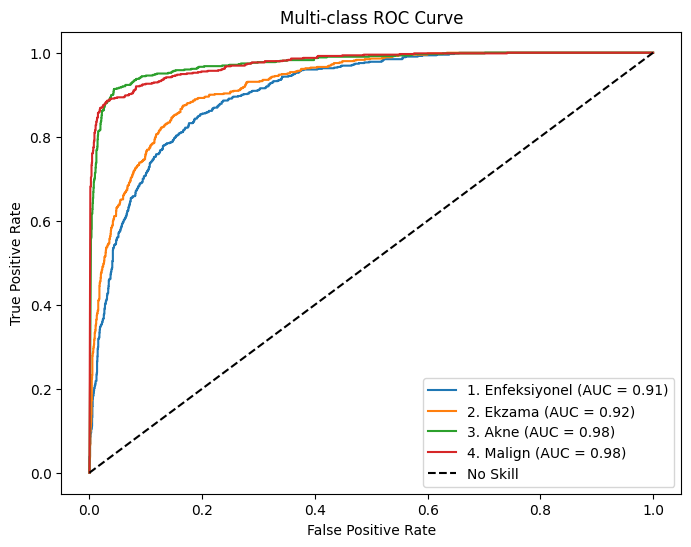

In [16]:
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()